In [1]:
#Import the necessary modules
import numpy as np
import rasterio as rt
import gdal
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
from rasterio.plot import show_hist
import rasterstats as rs
import rioxarray as rtx
import seaborn as sns

In [2]:
#Load Sentinel-2 bands for the calculation of vegetation indices
#The Sentinel-2 data is in projected coordinate system
path = ('forestBiomass/Sentinel/blackForest.tif')
with rt.open(path, 'r') as dataset:
    profile = dataset.profile
    bands = dataset.read(masked = True)
    floats = np.float_(bands)
    
print('No of Bands =', dataset.count)
print('CRS Projection =', dataset.crs)
print('Dataset Indexes = ', dataset.indexes)

No of Bands = 11
CRS Projection = EPSG:32632
Dataset Indexes =  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)


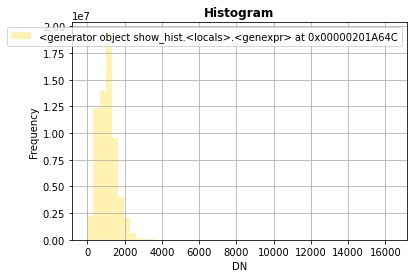

In [3]:
#Let take a look at a random band histogram
show_hist(floats[3], bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [32]:
# #Dispaly RGB stack
# RGB = np.dstack([floats[0], floats[1], floats[2]])
# RGB = RGB.astype(np.uint8)
# print(RGB.min)
# print(RGB.max)
# RGB = ((255 * RGB) / (np.max(RGB)))
# plt.figure(figsize = (16,12))
# plt.imshow(RGB)

In [4]:
#User define function to save and plot the vegetation indices

VI_output= 'forestBiomass/Vegation_ind/'

def export_to_tiff(raster_output_name, VI_name, plot_title, metadata):
    """
    This function get Numpy ndarray and related metadata to create
    a .tif file as the results of process.
    \nInputs=> A directory for exported .tif file, Numpy and meta
    \nOutputs=> A path to result .tif file
    """
    kwargs = metadata
    kwargs.update(dtype=rt.float32, count = 1)
    with rt.open(VI_output + raster_output_name, 'w', **kwargs) as dst:
        dst.write_band(1, VI_name.astype(rt.float32))
    plt.imshow(VI_name, cmap ='RdYlGn')
    plt.colorbar()

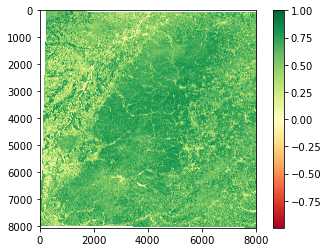

In [5]:
#Compute Normalized Difference Vegetation Index
#NDVI = B8 - B4 / B8 + B4
import os
np.seterr(divide='ignore', invalid='ignore')
NDVI = (floats[6].astype(float)- floats[2].astype(float)) / (floats[6] + floats[2])
export_to_tiff('1_NDVI.tiff', NDVI, 'NDVI_results', profile)

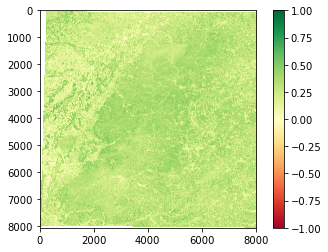

In [6]:
#Computer Normalized Difference Index
#NDi45 = B5 - B4 / B5 + b4
NDi45 = (floats[3].astype(float) - floats[2].astype(float)) / (floats[3] + floats[2])
export_to_tiff('2_NDI45.tiff', NDi45, 'NDI45_results', profile)

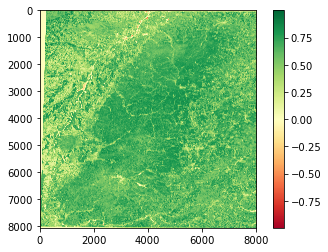

In [7]:
#Computer Soil Adjusted Vegetated Index
#(B8 - B4) / (B8 + B4 + L) * (1 + L)
l= 0.428
SAVI = (floats[6].astype(float) - floats[2].astype(float)) / (floats[6] + floats[2] + l * (1 + l))
export_to_tiff('3_SAVI.tiff', SAVI, 'SAVI_results', profile)

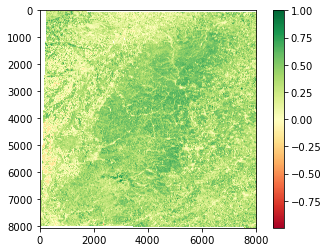

In [8]:
#Compute Nomralized Difference Moisture Index
#B8 - B11 / B8 + B11
NDMI = (floats[6].astype(float) - floats[9].astype(float)) / (floats[6] + floats[9])
export_to_tiff('4_NDMI.tiff', NDMI, 'NDMI_results', profile)

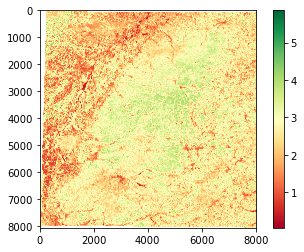

In [9]:
#Leaf Area Index
LAI= 0.57*np.exp(2.33*NDVI)
b = (LAI - np.min(LAI))/np.ptp(LAI)
export_to_tiff('5_LAI.tiff', LAI, 'LAI_results', profile)

In [10]:
#Import the Computed indices to generate a stack
glist = sorted(glob('forestBiomass/Vegation_ind/*.tiff'))
glist

['forestBiomass/Vegation_ind\\1_NDVI.tiff',
 'forestBiomass/Vegation_ind\\2_NDI45.tiff',
 'forestBiomass/Vegation_ind\\3_SAVI.tiff',
 'forestBiomass/Vegation_ind\\4_NDMI.tiff',
 'forestBiomass/Vegation_ind\\5_LAI.tiff']

In [11]:
#Read all the metadata of the raster bands
with rt.open(glist[0]) as dst:
    meta = dst.meta
meta.update(count = len(glist))
#Read each band of the vegetation indices and load them to rasterio
with rt.open('forestBiomass/Veg_stack/VIs_stack.tiff', 'w', **meta) as dst:
    for id, layer in enumerate(glist, start=1):
        with rt.open(layer) as src1:
            dst.write_band(id, src1.read(1))
#Save raster stack in the output folder
with rt.open('forestBiomass/Veg_stack/VIs_stack.tiff') as stack_src:
    stack_data= stack_src.read(masked=True)
    stack_meta= stack_src.profile
stack_meta #Display metadata of the stack

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 8009, 'height': 8051, 'count': 5, 'crs': CRS.from_epsg(32632), 'transform': Affine(13.544771831689351, 0.0, 386144.5956,
       0.0, -19.8310222208421, 5424768.8867), 'tiled': False, 'interleave': 'pixel'}

In [ ]:
#Prepare Training Dataset for the Models

In [2]:
#The forest biomass layer for 2018 was downloaded from https://data.ceda.ac.uk/neodc/esacci/biomass/data/agb/maps/v2.0/geotiff/2018
# The tiff tile for blackforest is N50E000_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2018-fv2.0.tiff
# Biomass reference values
biomass = gpd.read_file('forestBiomass/biomass/refbiomass.shp')
print(biomass.count())

biomass     200
geometry    200
dtype: int64


In [13]:
biomass.head()
#biomass.crs

,biomass,geometry
0,50.0,POINT (449197.507 5286408.366)
1,213.0,POINT (472433.569 5290911.006)
2,76.0,POINT (426539.449 5360977.579)
3,9.0,POINT (424574.624 5276863.030)
4,65.0,POINT (425933.253 5276589.244)


<AxesSubplot:>

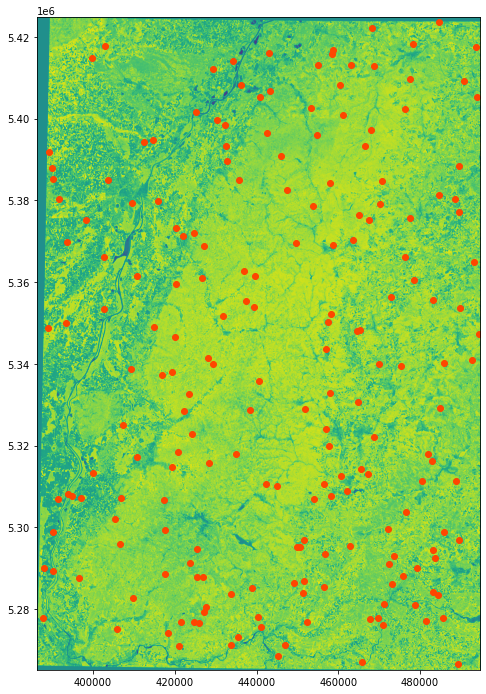

In [3]:
#Plot the refrence biomass values
VIs_stack = rt.open('forestBiomass/Veg_stack/VIs_stack.tiff')
fig, ax = plt.subplots(figsize = (16,12))
biomass.plot(ax=ax, color ='orangered')
show(VIs_stack, ax= ax)

In [15]:
#Creata a 20m buffer around the Biomass reference values
poly = biomass.copy() #Make a copy of the shapefile previously loaded
poly['geometry'] = biomass.geometry.buffer(20) #Create a 20m buffer around each refrence values and assign them to a geometry column
poly.head()
poly_buffer_path = ('forestBiomass/buffer_20m/poly_agb_buffer_20m.shp')
poly.to_file(poly_buffer_path) #Save the shapefile

In [2]:
#User define function to calculate zonal statitistics
def zonal_statistics(VI_data):
    VI_mean = rs.zonal_stats(poly_buffer_path,
                             VI_data.values,
                             nodata=-999,
                             affine=affine,
                             #affine= VI_data.rt.transform(),
                             geojson_out = True,
                             copy_properties=True,
                             stats="mean")
    return VI_mean

In [3]:
poly_buffer_path = ('forestBiomass/buffer_20m/poly_agb_buffer_20m.shp')
#Read the vegetation indices and extract the mean values within the buffer distance for the selected points.
NDVI_data = rtx.open_rasterio('forestBiomass/Vegation_ind/1_NDVI.tiff', masked= True).squeeze()
NDI45_data = rtx.open_rasterio('forestBiomass/Vegation_ind/2_NDI45.tiff', masked= True).squeeze()
SAVI_data = rtx.open_rasterio('forestBiomass/Vegation_ind/3_SAVI.tiff', masked= True).squeeze()
NDMI_data = rtx.open_rasterio('forestBiomass/Vegation_ind/4_NDMI.tiff', masked= True).squeeze()
LAI_data = rtx.open_rasterio('forestBiomass/Vegation_ind/5_LAI.tiff', masked= True).squeeze()

In [4]:

arr = rt.open('forestBiomass/Vegation_ind/1_NDVI.tiff', masked = True)
affine= arr.transform

In [5]:
#Calculate zonal statistics for each vegetation indice
NDVI_mean = zonal_statistics(NDVI_data)
NDI45_mean = zonal_statistics(NDI45_data)
SAVI_mean = zonal_statistics(SAVI_data)
NDMI_mean = zonal_statistics(NDMI_data)
LAI_mean = zonal_statistics(LAI_data)

In [6]:
# Create Geodata frame
def create_GeoDataFrame(VI_mean):
    VI_gdf = gpd.GeoDataFrame.from_features(VI_mean)
    return VI_gdf

def create_DataFrame(VI_gdf):
    VI_df = pd.DataFrame(VI_gdf.drop(columns='geometry'))
    #VI_df = VI_df.drop(columns=['OID_', 'POINT_X', 'POINT_Y'])
    return VI_df

In [7]:
#Generate Pandas dataframe from the Geopandas dataframe
#This data will be use to train the ML models
gdf1 = create_GeoDataFrame(NDVI_mean)
df1 = create_DataFrame(gdf1)
df1.rename(columns={'biomass': 'AGB_2017', 'mean':'NDVI'}, inplace= True)
gdf2 = create_GeoDataFrame(NDI45_mean)
df2 = create_DataFrame(gdf2)
df2.rename(columns={'mean':'NDI45'}, inplace= True)
gdf3 = create_GeoDataFrame(SAVI_mean)
df3 = create_DataFrame(gdf3)
df3.rename(columns={'mean':'SAVI'}, inplace = True)
gdf4 = create_GeoDataFrame(NDMI_mean)
df4 = create_DataFrame(gdf4)
df4.rename(columns={'mean':'NDMI'}, inplace = True)
gdf5= create_GeoDataFrame(LAI_mean)
df5 = create_DataFrame(gdf5)
df5.rename(columns={ 'mean':'LAI'}, inplace = True)

In [8]:
gdf4.head()

,geometry,biomass,mean
0,"POLYGON ((449217.507 5286408.366, 449217.411 5...",50.0,0.072139
1,"POLYGON ((472453.569 5290911.006, 472453.473 5...",213.0,0.282854
2,"POLYGON ((426559.449 5360977.579, 426559.352 5...",76.0,0.560360
3,"POLYGON ((424594.624 5276863.030, 424594.528 5...",9.0,0.294336
4,"POLYGON ((425953.253 5276589.244, 425953.156 5...",65.0,0.103558


In [9]:
df4.head()

,biomass,NDMI
0,50.0,0.072139
1,213.0,0.282854
2,76.0,0.560360
3,9.0,0.294336
4,65.0,0.103558


In [10]:
#Concentinate all them together
training_dataset = pd.concat([df1, df2, df3, df4, df5], axis = 1, join = 'inner')

In [11]:
training_dataset.head()

,AGB_2017,NDVI,biomass,NDI45,biomass,SAVI,biomass,NDMI,biomass,LAI
0,50.0,0.380788,50.0,0.150342,50.0,0.380719,50.0,0.072139,50.0,1.389981
1,213.0,0.667693,213.0,0.367836,213.0,0.667487,213.0,0.282854,213.0,2.754701
2,76.0,0.729360,76.0,0.303561,76.0,0.729246,76.0,0.560360,76.0,3.243413
3,9.0,0.567118,9.0,0.243255,9.0,0.567036,9.0,0.294336,9.0,2.143393
4,65.0,0.444399,65.0,0.181184,65.0,0.444310,65.0,0.103558,65.0,1.606942


In [12]:
#Remove the dubliacted column
training_dataset = training_dataset.drop(columns = ['biomass'])

In [13]:
training_dataset.head()

,AGB_2017,NDVI,NDI45,SAVI,NDMI,LAI
0,50.0,0.380788,0.150342,0.380719,0.072139,1.389981
1,213.0,0.667693,0.367836,0.667487,0.282854,2.754701
2,76.0,0.729360,0.303561,0.729246,0.560360,3.243413
3,9.0,0.567118,0.243255,0.567036,0.294336,2.143393
4,65.0,0.444399,0.181184,0.444310,0.103558,1.606942


In [14]:
#Save the dataset as a csv
training_dataset.to_csv('forestBiomass/training/training_dataset.csv', header = True, index= False)

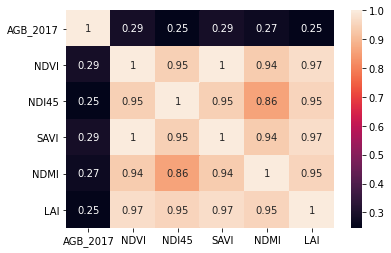

In [15]:
#Lets take a look at the correlation matrix
corrMatrix = training_dataset.corr()
sns.heatmap(corrMatrix, annot = True)
plt.show()

<AxesSubplot:xlabel='LAI', ylabel='AGB_2017'>

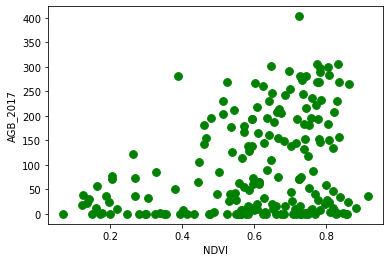

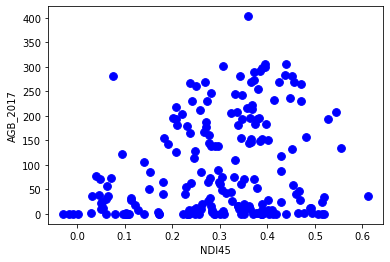

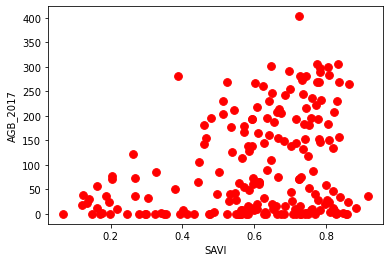

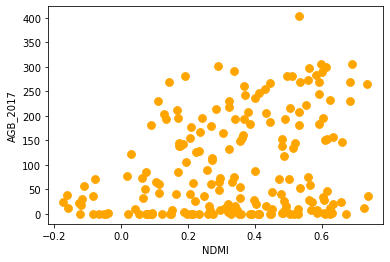

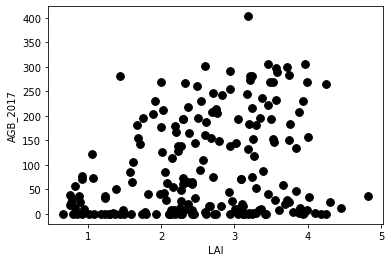

In [2]:
#As well as their linear realtionsip
df = pd.read_csv('forestBiomass/training/training_dataset.csv')
df.plot.scatter(x='NDVI', y='AGB_2017', s=60, c= 'green')
df.plot.scatter(x='NDI45', y='AGB_2017', s=60, c= 'blue')
df.plot.scatter(x='SAVI', y='AGB_2017', s=60, c= 'red')
df.plot.scatter(x='NDMI', y='AGB_2017', s=60, c= 'orange')
df.plot.scatter(x='LAI', y='AGB_2017', s=60, c= 'black')

In [3]:
#Multiple Linear regression model
#Load the independent variables
X = df.iloc[:, 1:6].values
#Load the dependent variables
y = df.iloc[:, 0].values

In [19]:
#!pip install statsmodels

In [4]:
#Multiple Linear Regression model training
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
#Preperation of training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

from sklearn.linear_model import LinearRegression
mlr_regressor = LinearRegression()
mlr_regressor.fit(X_train, y_train)
y_pred = mlr_regressor.predict(X_test)

#Write results to seperate dataframe and display
mlr_results = {'Intercept': [mlr_regressor.intercept_],
               'Coefficients': [mlr_regressor.coef_],
               'r-squared score': [mlr_regressor.score(X_train, y_train)]}
mlr_df = pd.DataFrame(mlr_results, columns = ['Intercept', 'Coefficients', 'r-squared score'])
mlr_df

,Intercept,Coefficients,r-squared score
0,85.555296,"[1216275.3740563213, 207.50298216946396, -1216...",0.488269


In [5]:
#Random Forest Model Training
features = df.iloc[:, 1:6].values
AGB_obs = df.iloc[:, 0].values

from sklearn.model_selection import train_test_split
train_features, test_features, train_AGB_obs, test_AGB_obs = train_test_split(features, AGB_obs, test_size = 0.3, random_state = 0)

from sklearn.ensemble import RandomForestRegressor
RFReg = RandomForestRegressor(n_estimators=100, max_depth =3, n_jobs= -1, random_state = 0)
RFReg.fit(train_features, train_AGB_obs) #Fit the training dataset into the model


RandomForestRegressor(max_depth=3, n_jobs=-1, random_state=0)

In [6]:
#Predict AGB values based on the created model with parameters pre-defined
AGB_obs_pred_rf = RFReg.predict((test_features))
from sklearn import metrics
r_square_rf = metrics.r2_score(test_AGB_obs, AGB_obs_pred_rf)
print('r-squared', r_square_rf)

r-squared -0.003734505184413761


In [7]:
#Lets produce the numerical values of the importance of each VIs values for the final model
rf_features = df.iloc[:, 1:6]
features_list = list(rf_features.columns)
importances = list(RFReg.feature_importances_)
#The value of the importance will be calculated based on the model
feature_importances = [(feature, round(importance,2)) for feature, importance in zip(features_list,importances)]
feature_importances = sorted(feature_importances, key =lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: NDI45                Importance: 0.31
Variable: LAI                  Importance: 0.21
Variable: NDMI                 Importance: 0.2
Variable: NDVI                 Importance: 0.15
Variable: SAVI                 Importance: 0.12


In [14]:
#User define Function to save the Geotiff
def createGeotiff(outRaster, estimation_array, geo_transform, projection):
    driver = gdal.GetDriverByName('GTIFF')
    rows, cols = estimation_array.shape
    rasterDS = driver.Create(outRaster, cols, rows, 1, gdal.GDT_Float32)
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(estimation_array)
    rasterDS= None

In [15]:
#Above Ground Biomass based on Multiple Regression Model on the VIs_Stack
inRaster = 'forestBiomass/Veg_stack/VIs_stack.tiff'
df_train = pd.read_csv('forestBiomass/training/training_dataset.csv')
data = df_train[['NDVI','NDI45','SAVI','NDMI','LAI']] #Independent variables
label = df_train['AGB_2017'] #Predicted Variable dependent
ds =gdal.Open(inRaster, gdal.GA_ReadOnly)
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount
geo_transform = ds.GetGeoTransform()
projection = ds.GetProjectionRef()
array = ds.ReadAsArray()
ds= None
array = np.stack(array, axis =2)
array = np.reshape(array, [rows*cols, bands])
test= pd.DataFrame(array, dtype='float32')
outRaster = 'forestBiomass/esti_biomass/Biomasslrm.tiff'

#Prediction of aboveground biomass values based on the training set and the raster stack provided
AGB_mlr = mlr_regressor.predict(test)
estimation = AGB_mlr.reshape((rows, cols))


#Export classified iamge using 'CreateGeotiff' function provided in the section number 3
createGeotiff(outRaster, estimation, geo_transform, projection)

In [16]:
#Above Ground Biomass Based on Random Forest
inpRaster = 'forestBiomass/Veg_stack/VIs_stack.tiff'
outRaster = 'forestBiomass/esti_biomass/Biomassrf.tiff'
df_train = pd.read_csv('forestBiomass/training/training_dataset.csv')
data = df_train[['NDVI', 'NDI45', 'SAVI', 'NDMI', 'LAI']]
label = df_train['AGB_2017']
ds = gdal.Open(inpRaster, gdal.GA_ReadOnly)
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount
geo_transform = ds.GetGeoTransform()
projection = ds.GetProjectionRef()
array = ds.ReadAsArray()
ds= None
array = np.stack(array, axis =2)
array = np.reshape(array, [rows*cols, bands])
test1 = pd.DataFrame(array, dtype= 'float32')

#Prediction of above ground biomass values based on the training dataset and the raster stack provided
AGB_RFReg = RFReg.predict(test1)
estimation = AGB_RFReg.reshape((rows, cols))

createGeotiff(outRaster, estimation, geo_transform, projection)

In [18]:
#Read the output rasters
AGB_mlr = rt.open('forestBiomass/esti_biomass/Biomasslrm.tiff')
AGB_mlr_array = AGB_mlr.read()
#Calcualte statistics for the images
stats = []

for band in AGB_mlr_array:
    stats.append({'min': band.min(),
                 'mean': band.mean(),
                 'median': np.median(band),
                 'max': band.max()})
print(stats)

[{'min': -27040.322, 'mean': 93.92469, 'median': 71.97943, 'max': 461163.38}]


In [20]:
AGB_RF = rt.open('forestBiomass/esti_biomass/Biomassrf.tiff')
AGB_RF_array = AGB_RF.read()

stats = []
for band in AGB_RF_array:
    stats.append({'min': band.min(),
                 'mean': band.mean(),
                 'median': np.median(band),
                 'max':band.max()})
print(stats)

[{'min': 21.428658, 'mean': 88.44667, 'median': 92.9195, 'max': 191.84142}]


Text(0.5, 1.0, 'AGB[tons/ha] - Refrence')

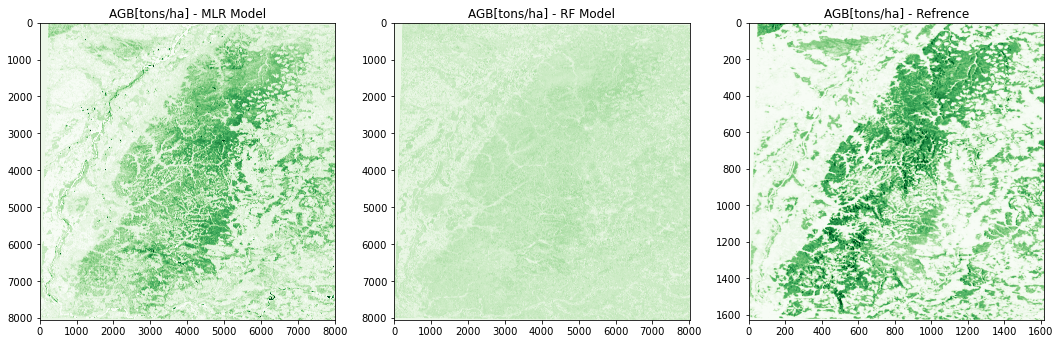

In [29]:
AGB_ref = rt.open('forestBiomass/biomass_tif/biomass_m.tif')
AGB_ref_array = AGB_ref.read()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(18,18))
ax1.imshow(AGB_mlr_array[0], cmap = 'Greens', vmin = 0, vmax = 400)
ax1.set_title('AGB[tons/ha] - MLR Model')
ax2.imshow(AGB_RF_array[0], cmap = ('Greens'), vmin = 0, vmax = 400)
ax2.set_title('AGB[tons/ha] - RF Model')
ax3.imshow(AGB_ref_array[0], cmap = 'Greens', vmin = 0, vmax = 400)
ax3.set_title('AGB[tons/ha] - Refrence')